# Instrument response function from Data Level 2


In this notebook we will analyze the Monte Carlo data sample.

Here we will check the gammaness, which is a parameter that tells us how likely an event is to be a $\gamma$ ray, the reconstructed energy, the reconstructed direction of the incoming $\gamma$ rays, the instrument effective area, the energy bias, and play a bit with all of them.


### As usual, let's start by loading some modules

In [1]:
import itertools
import operator
import glob
import numpy as np
from astropy import units as u
from astropy.table import Table, QTable, vstack
from magicctapipe.io import load_mc_dl2_data_file
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib import pyplot as plt
from pyirf.benchmarks import angular_resolution, energy_bias_resolution
from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.irf import effective_area_per_energy

In [2]:
# Configure the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "dotted"}
)

# Get the pyplot default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load MC DL2 data files

The data used here is available at the IT Container or at PIC.  

In this example we download the data to the directory ./dataMC/  
Let's start by setting some parameters and listing the input files with _glob_:

In [3]:
quality_cuts= f"(disp_diff_mean < {np.sqrt(0.05)})"
irf_type="software"
dl2_weight_type="intensity"
energy_bins=np.logspace(-2,3,15)[2:]

input_file_gamma = glob.glob('./data/MC/gammas/*zd_[1-4]*.h5')
input_file_gamma.sort()

print(f"{len(input_file_gamma)} gamma files are found")

input_file_proton = glob.glob('./data/MC/protons/*zd_[1-4]*.h5')
input_file_proton.sort()

print(f"{len(input_file_proton)} proton files are found")

2 gamma files are found
2 proton files are found


Now let's load these input files and check their contents (this can be quite heavy for your personal computer). We will call the gamma ray table "signal_hist", and the protons table "background_hist".

In [4]:
print("Loading the input files...")

signal_hist=[]
background_hist=[]
signal_hist_6_26=[]
signal_hist_26_46=[]
signal_hist_46_67=[]

#First we do for the gammas:
for i_file, input_file in enumerate(input_file_gamma):
    # Load the input file
    sig_hist, point_sig, sim_isto_signal =load_mc_dl2_data_file(
        input_file, quality_cuts, irf_type, dl2_weight_type
    )
    
    if point_sig[0]<=26:
        signal_hist_6_26=vstack([signal_hist_6_26,sig_hist])
    elif point_sig[0]<=46:
        signal_hist_26_46=vstack([signal_hist_26_46,sig_hist])
    elif point_sig[0]<=67:
        signal_hist_46_67=vstack([signal_hist_46_67,sig_hist])
    signal_hist=vstack([signal_hist,sig_hist])

#And then for the protons:
for i_file, input_file in enumerate(input_file_proton):
    # Load the input file
    back_hist, point_back, sim_isto_back =load_mc_dl2_data_file(
        input_file, quality_cuts, irf_type, dl2_weight_type
   
    ) 
    
    background_hist=vstack([background_hist,back_hist])


Loading the input files...



In total 452562 stereo events are found:
    M1_M2 (type 0): 10881 events (2.4%)
    LST1_M1 (type 1): 57331 events (12.7%)
    LST1_M2 (type 2): 127552 events (28.2%)
    LST1_M1_M2 (type 3): 256798 events (56.7%) 

Extracting the events of the 'software' type...
--> 280754 stereo events

In total 486606 stereo events are found:
    M1_M2 (type 0): 7781 events (1.6%)
    LST1_M1 (type 1): 66336 events (13.6%)
    LST1_M2 (type 2): 126052 events (25.9%)
    LST1_M1_M2 (type 3): 286437 events (58.9%) 

Extracting the events of the 'software' type...
--> 314662 stereo events

In total 1163 stereo events are found:
    M1_M2 (type 0): 55 events (4.7%)
    LST1_M1 (type 1): 205 events (17.6%)
    LST1_M2 (type 2): 572 events (49.2%)
    LST1_M1_M2 (type 3): 331 events (28.5%) 

Extracting the events of the 'software' type...
--> 423 stereo events

In total 1356 stereo events are found:
    M1_M2 (type 0): 54 events (4.0%)
    LST1_M1 (type 1): 236 events (17.4%)
    LST1_M2 (type 2): 613 

973
595416


And this is how these tables look like:

In [13]:
signal_hist

col0,obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,101,2303,2,2,0.04253404587507248,79.67462795125147,246.801263167297,1.3962633523615238,4.330458607644663,0.045447771564922045,79.89771824222048,246.64518278716346,0.9355382724131033,0.22480030477503513,0.39968059690418656,0.2764763460786716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
--,50001,1994503,3,3,0.07419008016586304,66.42727798052582,258.270981274446,1.158374994449637,4.525027741086645,0.08344957717143606,66.34403526376113,258.2659141082133,0.943620523290858,0.08326746039094289,0.4020693253074038,0.40150247946777723
--,50001,1996600,3,3,0.08630689233541489,66.45790454876415,258.28491486035284,1.158374994449637,4.525027741086645,0.11713383792944784,66.43790646927201,258.24784181867795,0.9278109959195147,0.024887149852965747,0.4018814786836681,0.41277018715011826


In [18]:
background_hist

col0,obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,803,1765407,3,3,0.7135063409805298,73.75620756373289,249.54249128878993,1.2900252419381246,4.3966588866648575,0.20558964893077877,73.7733556934708,249.10186914834165,0.8527215625870825,0.12437721926164633,0.6774829667560053,0.7937125982560594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
--,99902,5433306,3,3,21.420501708984375,67.0074342486267,262.17115589430665,1.1665606435676779,4.550754057515486,13.729414893648514,66.93480139896081,262.0653115844927,0.6010107789626742,0.08360600808414483,0.5860628296670654,0.5293694468735338
--,99902,5869502,1,2,39.019107818603516,61.32279757601931,261.2183718258466,1.1665606165244742,4.550754069709616,7.689348895675395,66.99958801957985,259.86263659494324,0.04196902852920755,5.707113004746009,5.520138297788477,0.37923360383749666


If you take a look at the colum "gammaness" in both tables, you will see that the values of gammaness for the protons is smaller than for the gamma rays. This means that the classification of events was good, but let's do a couple of plots to better compare.

### Gammaness 

Let's compare these two MC samples, i.e. gammas and protons, in terms of their distributions of gammaness. Let's start with the simulated gamma rays:

Text(0.5, 1.0, 'Simulated gamma rays')

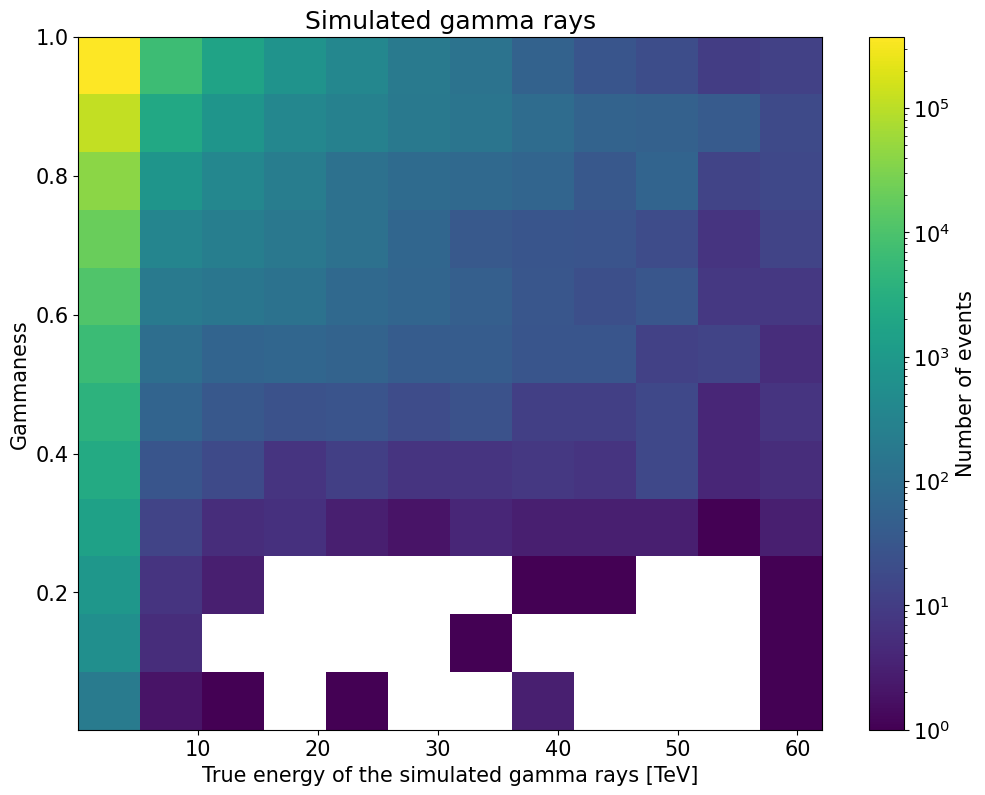

In [17]:
x=np.array(signal_hist['true_energy'].value)
y=np.array(signal_hist['gammaness'].value)
plt.figure()
plt.xlabel("True energy of the simulated gamma rays [TeV]")
plt.ylabel("Gammaness")
plt.hist2d(x,y, bins=12,  norm=mpl.colors.LogNorm())
plt.colorbar(label="Number of events")
plt.title("Simulated gamma rays")

The plot above seems quite good because most of the simulated gamma rays indeed have high values of gammaness. Now look how terrible is the gammaness distribution for protons:

Text(0.5, 1.0, 'Simulated protons')

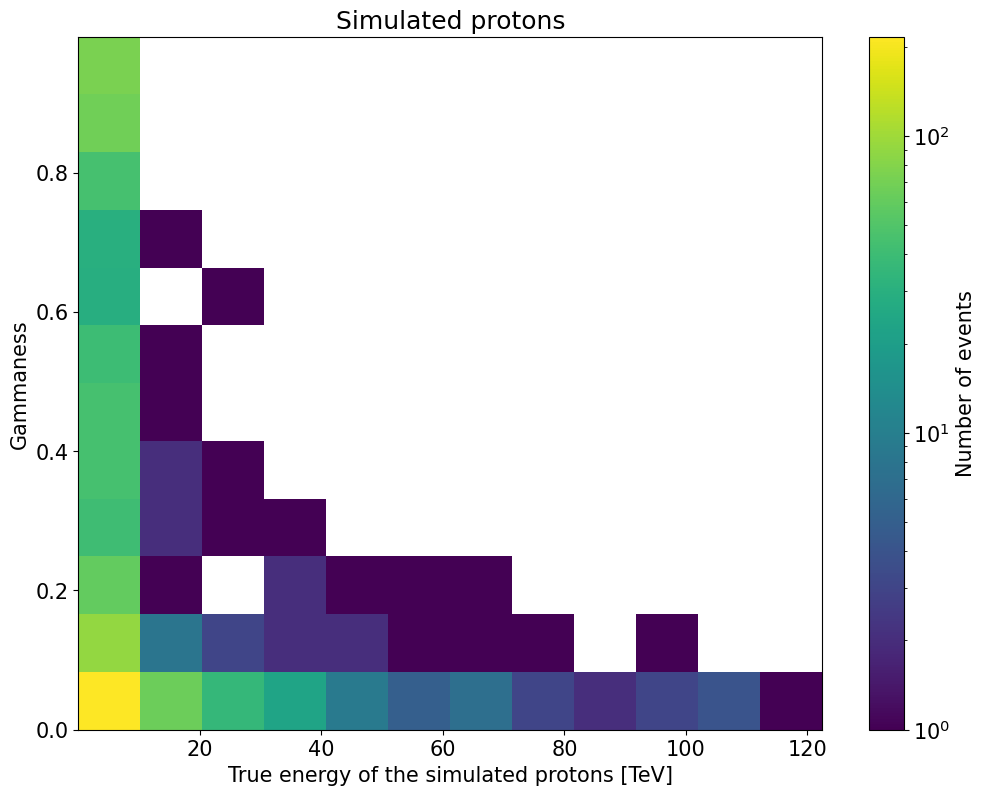

In [20]:
x=np.array(background_hist['true_energy'].value)
y=np.array(background_hist['gammaness'].value)
plt.figure()
plt.xlabel("True energy of the simulated protons [TeV]")
plt.ylabel("Gammaness")
plt.hist2d(x,y, bins=12,  norm=mpl.colors.LogNorm())
plt.colorbar(label="Number of events")
plt.title("Simulated protons")

This means that protons and gamma rays are quite well distinguished by our classification.


### Migration matrix

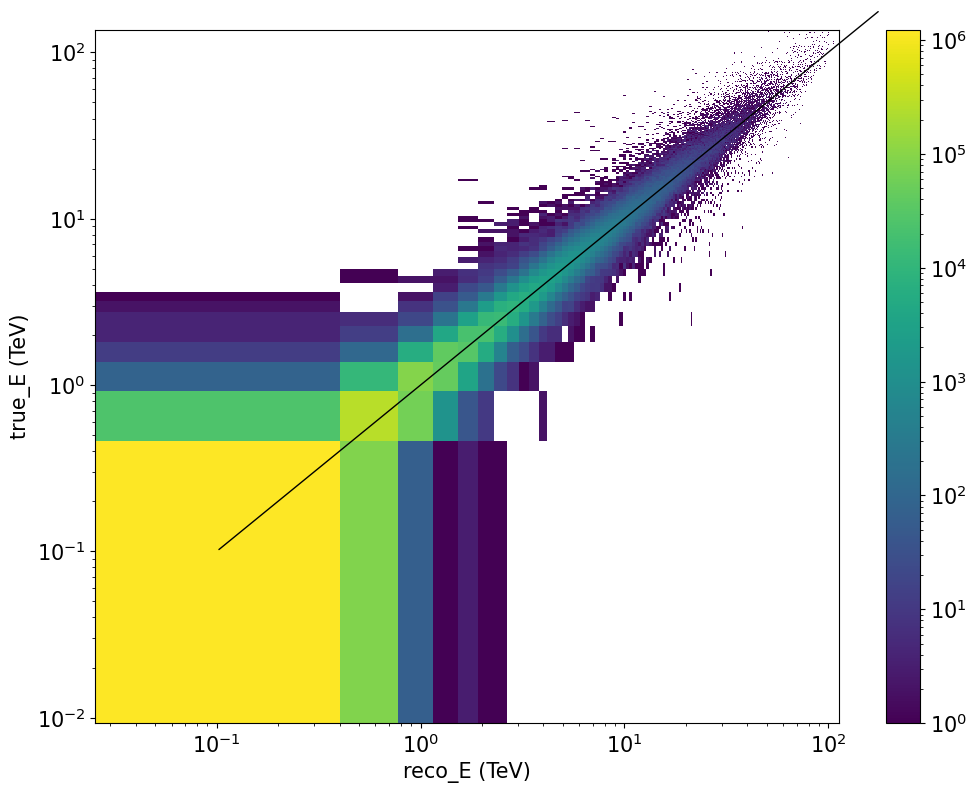

In [43]:
x=np.array(signal_hist['reco_energy'].value)
y=np.array(signal_hist['true_energy'].value)
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("reco_E (TeV)")
plt.ylabel("true_E (TeV)")
plt.hist2d(x,y, bins=300,  norm=mpl.colors.LogNorm())
plt.annotate("",
              xy=(0.1,0.1), xycoords='data',
              xytext=(180,180), textcoords='data',
              arrowprops=dict(arrowstyle="-",
                              connectionstyle="arc3,rad=0."), 
              )
plt.colorbar()

# Check the reconstructed energy

Energy bins:
[5.17947468e-02 1.17876863e-01 2.68269580e-01 6.10540230e-01
 1.38949549e+00 3.16227766e+00 7.19685673e+00 1.63789371e+01
 3.72759372e+01 8.48342898e+01 1.93069773e+02 4.39397056e+02
 1.00000000e+03] TeV
Energy bins center:
[8.48358051e-02 1.93073222e-01 4.39404905e-01 1.00001786e+00
 2.27588658e+00 5.17956720e+00 1.17878969e+01 2.68274371e+01
 6.10551135e+01 1.38952031e+02 3.16233414e+02 7.19698528e+02] TeV


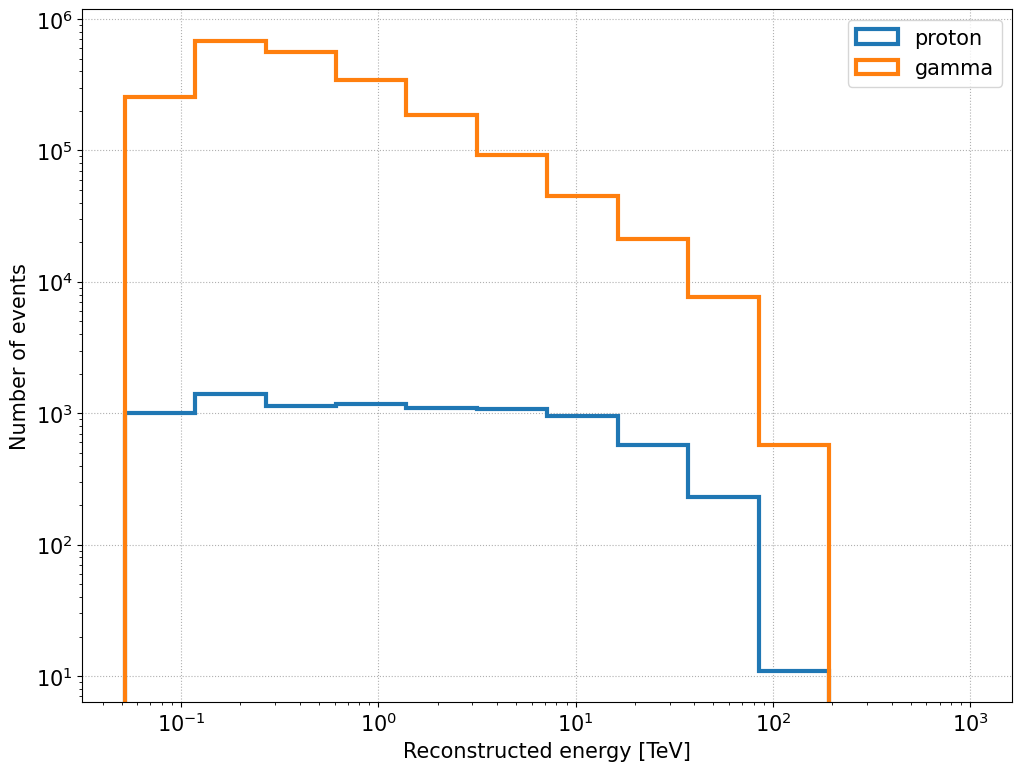

In [44]:
# ================
# === Settings ===
# ================


yscale = "log"

# ============
# === Main ===
# ============

print(f"Energy bins:\n{energy_bins} TeV")

energy_bins_center = (energy_bins[:-1] + energy_bins[1:]) / 2

energy_bins_width = [
    energy_bins[1:] - energy_bins_center,
    energy_bins_center - energy_bins[:-1],
]
print(f"Energy bins center:\n{energy_bins_center} TeV")
plt.figure()
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Number of events")
plt.semilogx()
plt.yscale(yscale)
plt.grid()
E_back=np.array(background_hist["reco_energy"].value)
E_sig=np.array(signal_hist["reco_energy"].value)
# Plot the background energy distribution
plt.hist(
    E_back,
    bins=energy_bins,
    label="proton",
    histtype="step",
    linewidth=3,
)

# Plot the signal energy distribution
plt.hist(
    E_sig,
    bins=energy_bins,
    label="gamma",
    histtype="step",
    linewidth=3,
)

plt.legend()

# Check the gammaness

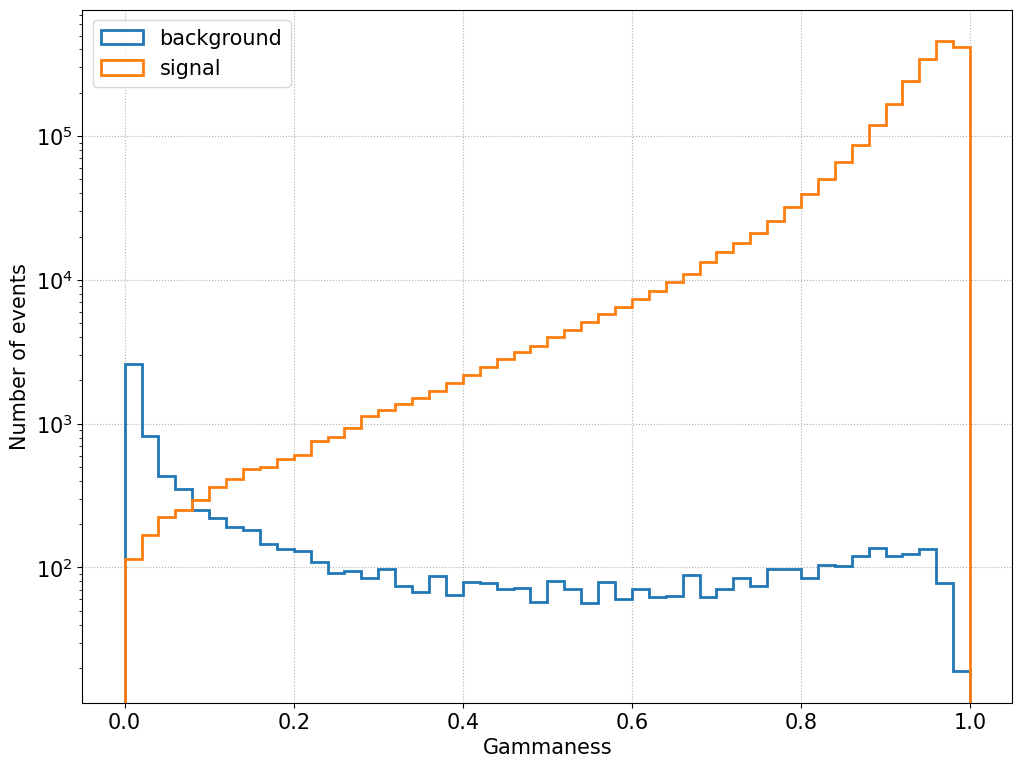

In [45]:
# ================
# === Settings ===
# ================

gh_bins = np.linspace(0, 1, 51)
yscale = "log"

# ============
# === Main ===
# ============

plt.figure()
plt.xlabel("Gammaness")
plt.ylabel("Number of events")
plt.yscale(yscale)
plt.grid()
g_back=np.array(background_hist["gammaness"].value)
g_sig=np.array(signal_hist["gammaness"].value)
#Plot the background gammaness distribution
plt.hist(
    g_back,
    bins=gh_bins,
    label="background",
    histtype="step",
    linewidth=2,
)

# Plot the signal gammaness distribution
plt.hist(
    g_sig,
    bins=gh_bins,
    label="signal",
    histtype="step",
    linewidth=2,
)

plt.legend(loc="upper left")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


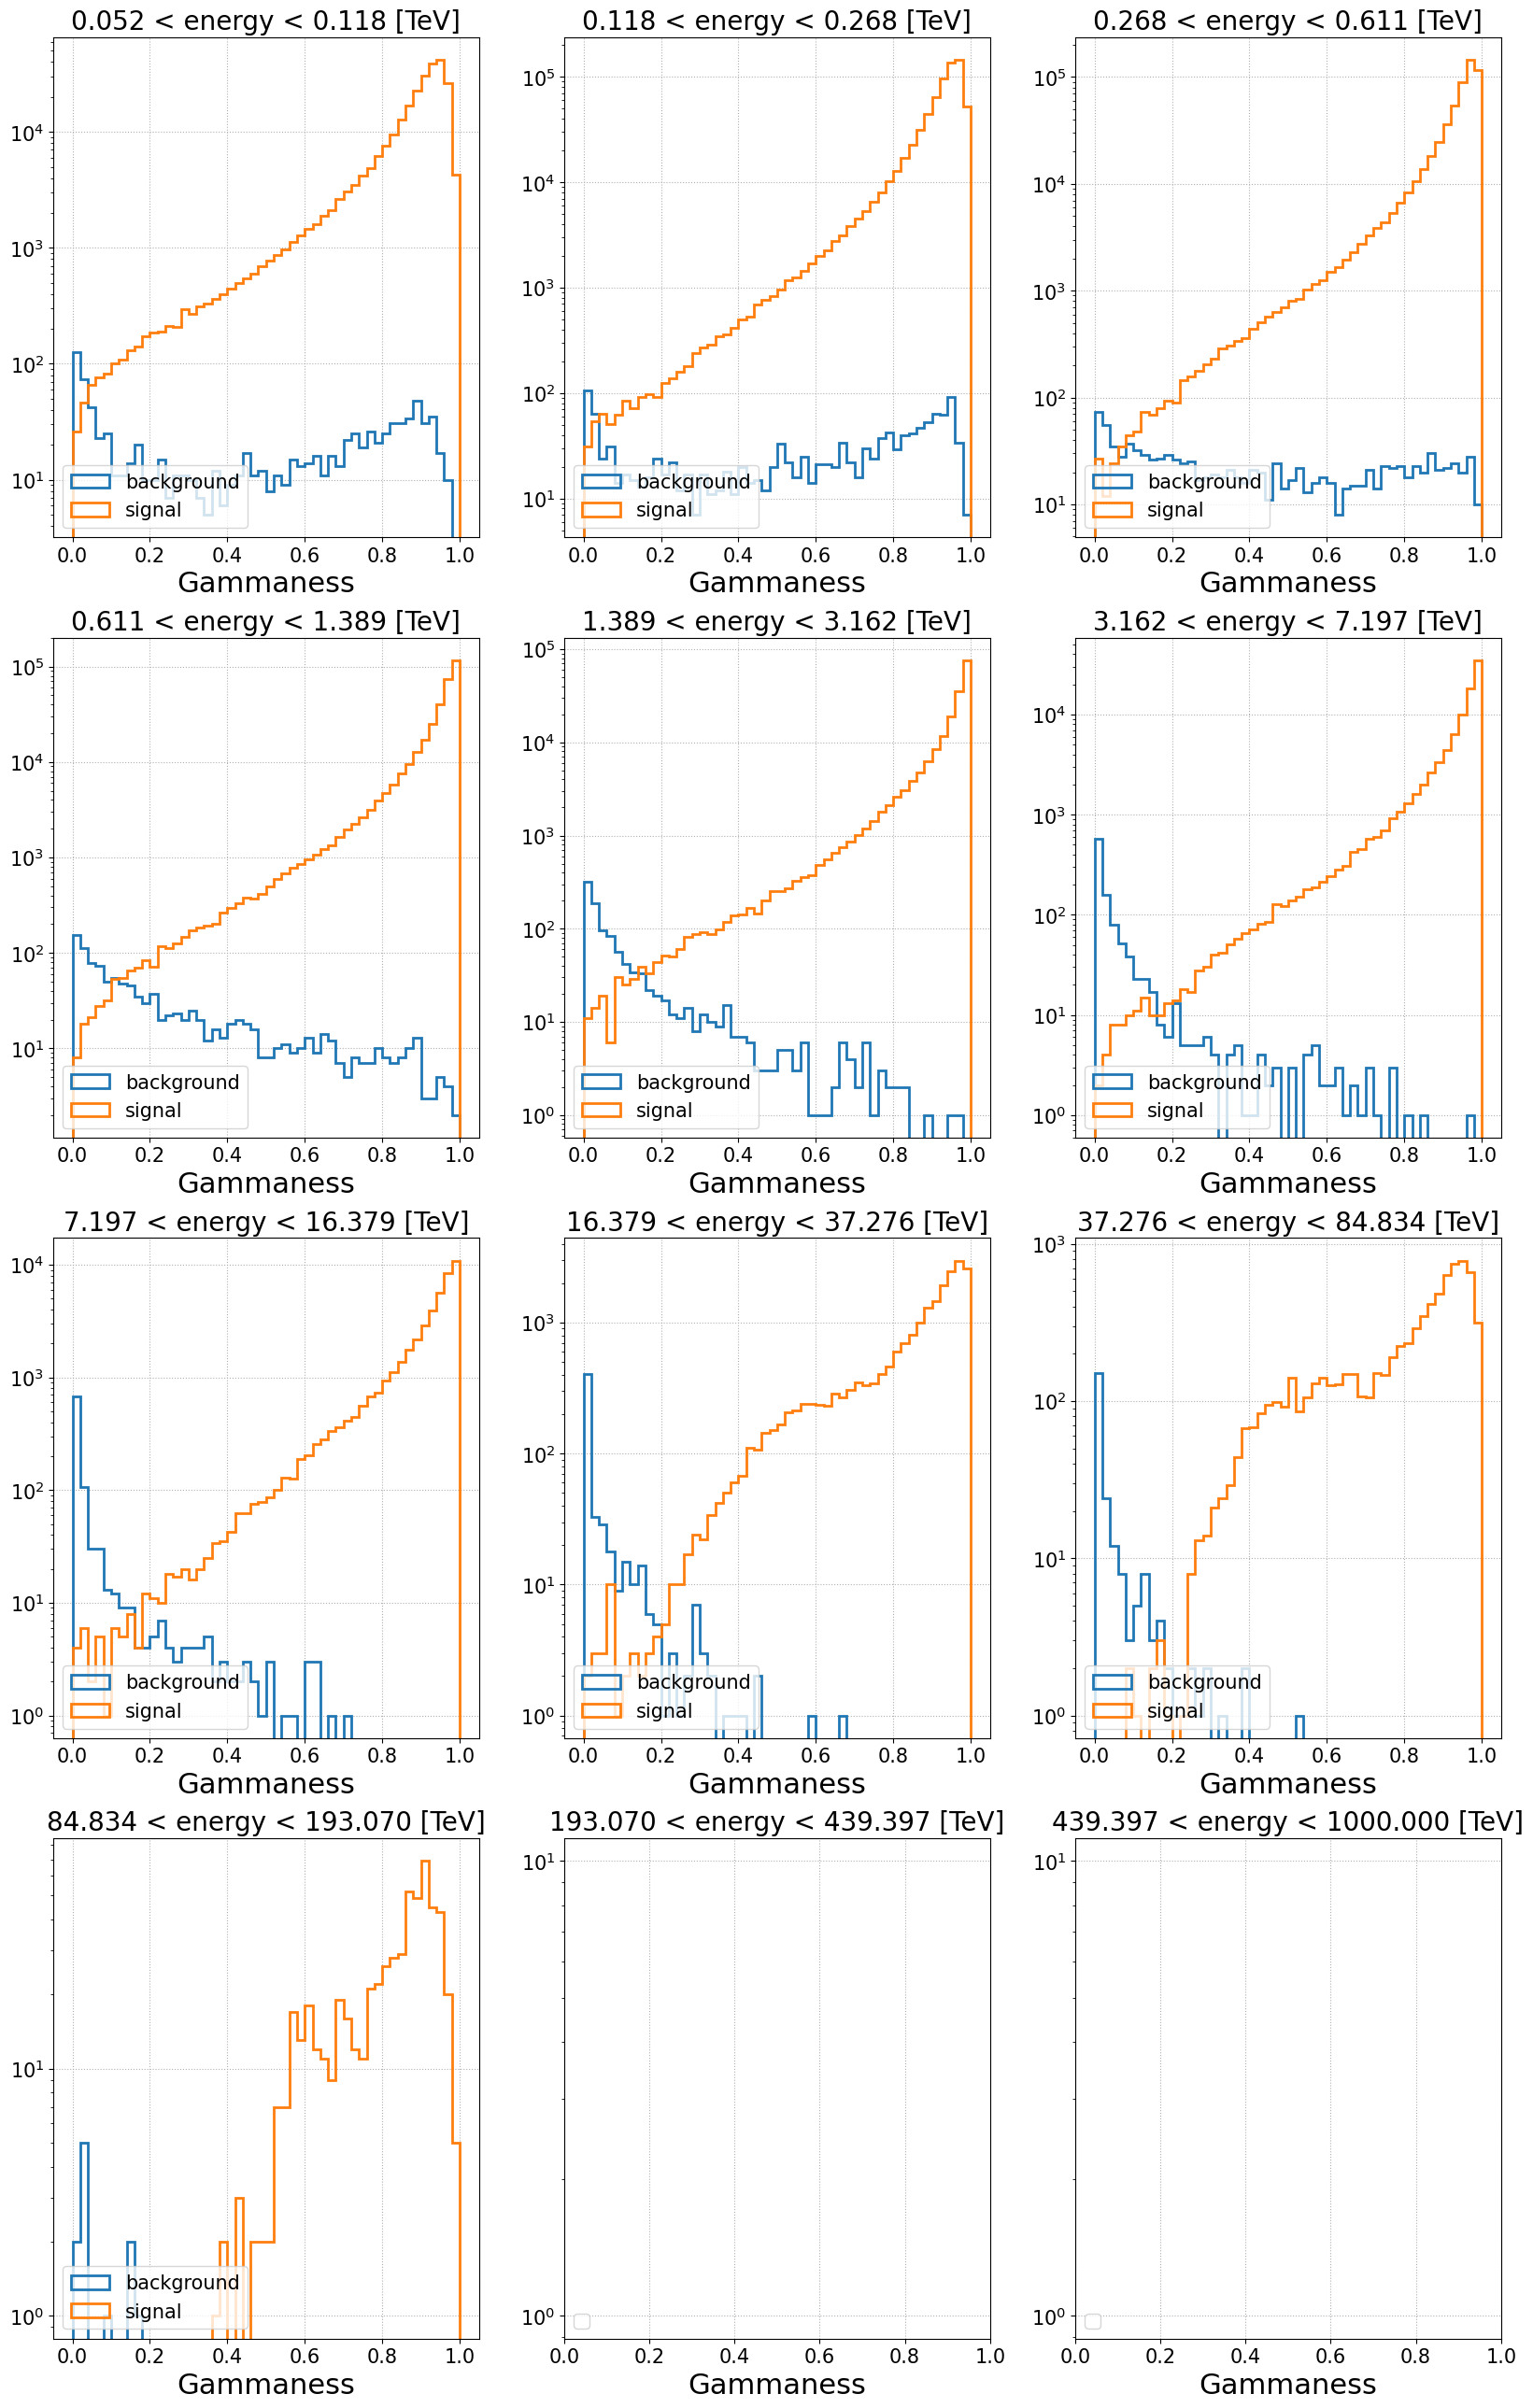

In [46]:
n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lolim:.3f} < energy < {eng_uplim:.3f} [TeV]", fontsize=20)
    plt.xlabel("Gammaness", fontsize=22)
    plt.yscale(yscale)
    plt.grid()

    # Apply the energy cuts
    cond_back_lolim = background_hist["reco_energy"].value > eng_lolim
    cond_back_uplim = background_hist["reco_energy"].value < eng_uplim

    cond_signal_lolim = signal_hist["reco_energy"].value > eng_lolim
    cond_signal_uplim = signal_hist["reco_energy"].value < eng_uplim

    condition_back = np.logical_and(cond_back_lolim, cond_back_uplim)
    condition_signal = np.logical_and(cond_signal_lolim, cond_signal_uplim)

    dt_back = background_hist[condition_back]
    dt_signal = signal_hist[condition_signal]

    # Plot the background gammaness distribution
    if len(dt_back) > 0:
        plt.hist(
             dt_back["gammaness"].value,
             bins=gh_bins,
             label="background",
             histtype="step",
             linewidth=2,
       )

    # Plot the signal gammaness distribution
    if len(dt_signal) > 0:
        plt.hist(
            dt_signal["gammaness"].value,
            bins=gh_bins,
            label="signal",
            histtype="step",
            linewidth=2,
        )

    plt.legend(loc="lower left")


# Apply dynamic gammaness cuts

In [47]:
# ================
# === Settings ===
# ================

gh_efficiency = 0.9

# ============
# === Main ===
# ============

print(f"Efficiency: {gh_efficiency}")

gh_percentile = 100 * (1 - gh_efficiency)


# Calculate the dynamic gammaness cuts
gh_table_eff = calculate_percentile_cut(
    values=signal_hist["gammaness"],
    bin_values=signal_hist["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=0.0,
    percentile=gh_percentile,
)

gh_cuts_eff = gh_table_eff["cut"].value
print(f"\n efficiency gammaness cuts:\n{gh_cuts_eff}")

Efficiency: 0.9

 efficiency gammaness cuts:
[0.72713928 0.81095066 0.82658405 0.82716766 0.83105043 0.82702536
 0.77144891 0.61258808 0.51542908 0.60281844 0.         0.32927873]


<ErrorbarContainer object of 3 artists>

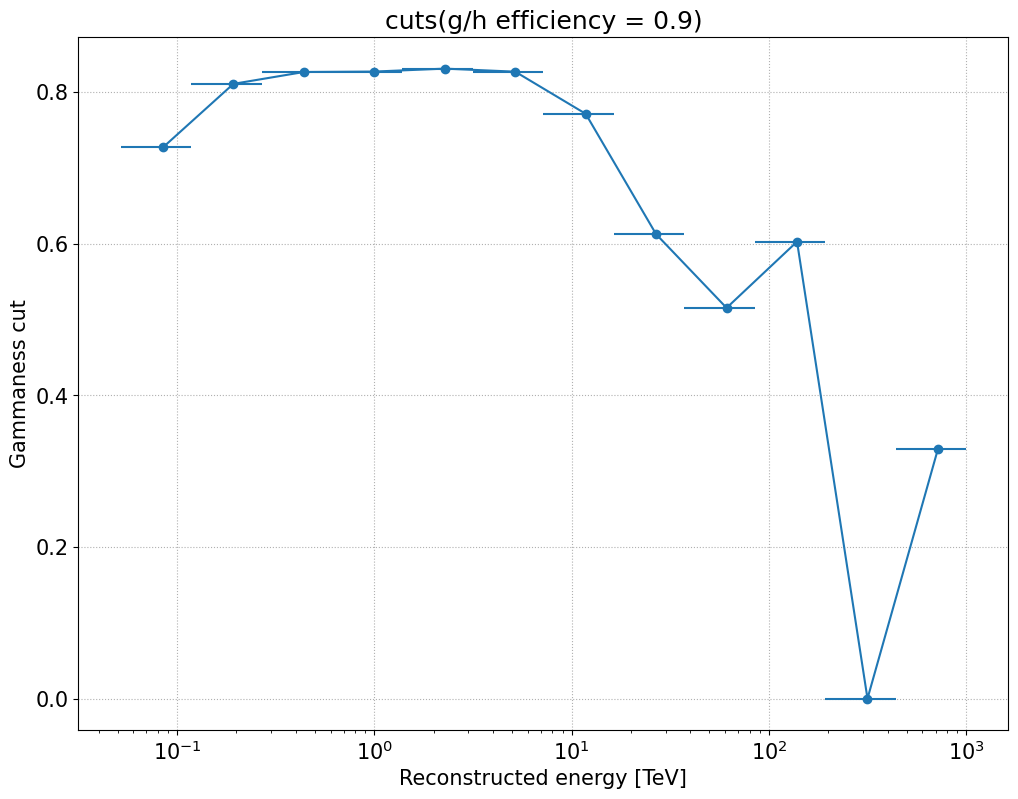

In [48]:
plt.figure()
plt.title(f"cuts(g/h efficiency = {gh_efficiency})")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Gammaness cut")
plt.semilogx()
plt.grid()


# Plot the dynamic gammaness cuts
plt.errorbar(
    x=energy_bins_center,
    y=gh_cuts_eff,
    xerr=energy_bins_width,
    label="gamma efficiency",
    marker="o",
)



In [49]:


print("\nApplying the gammaness cuts...")




mask_gh_eff = evaluate_binned_cut(
    values=signal_hist["gammaness"],
    bin_values=signal_hist["reco_energy"],
    cut_table=gh_table_eff,
    op=operator.ge,
)

data_eff_gcut = signal_hist[mask_gh_eff]
print(f"--> Number of events: {len(data_eff_gcut)}")


mask_gh_eff_26 = evaluate_binned_cut(
    values=signal_hist_6_26["gammaness"],
    bin_values=signal_hist_6_26["reco_energy"],
    cut_table=gh_table_eff,
    op=operator.ge,
)

data_eff_gcut_26 = signal_hist_6_26[mask_gh_eff_26]
  
    
mask_gh_eff_46 = evaluate_binned_cut(
    values=signal_hist_26_46["gammaness"],
    bin_values=signal_hist_26_46["reco_energy"],
    cut_table=gh_table_eff,
    op=operator.ge,
)

data_eff_gcut_46 = signal_hist_26_46[mask_gh_eff_46]



mask_gh_eff_67 = evaluate_binned_cut(
    values=signal_hist_46_67["gammaness"],
    bin_values=signal_hist_46_67["reco_energy"],
    cut_table=gh_table_eff,
    op=operator.ge,
)

data_eff_gcut_67 = signal_hist_46_67[mask_gh_eff_67]




Applying the gammaness cuts...
--> Number of events: 1979320


# Check the reconstructed direction

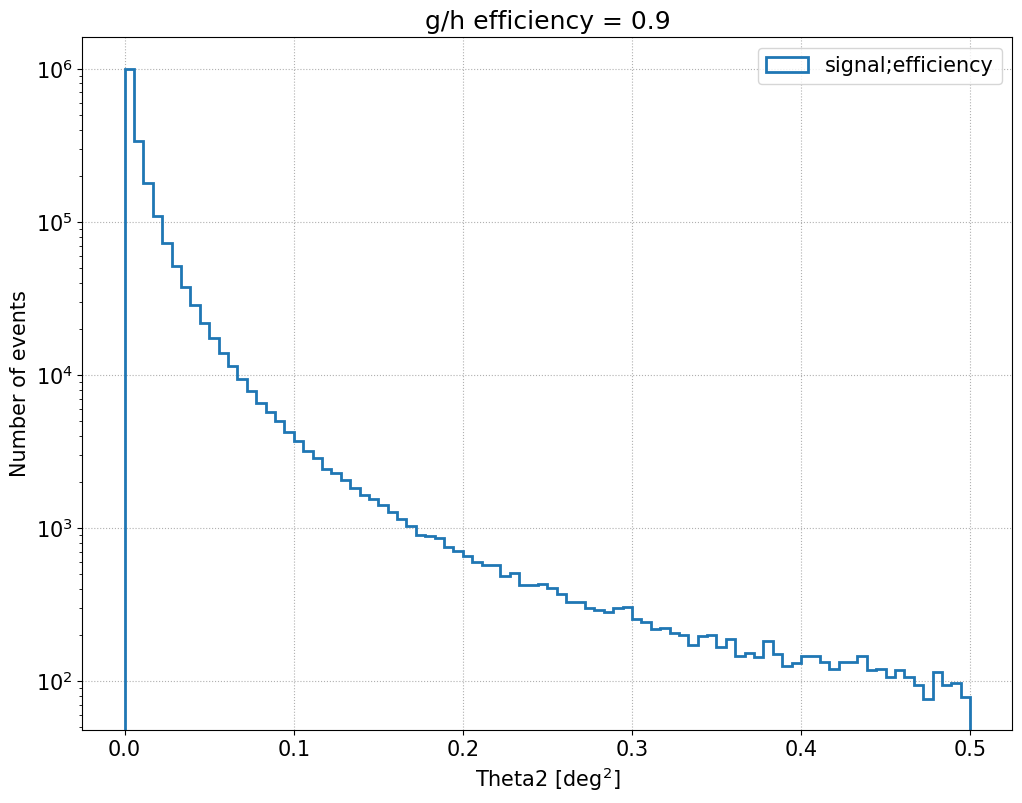

In [50]:
# ================
# === Settings ===
# ================

theta2_bins = np.linspace(0, 0.5, 91)
yscale = "log"

# ============
# === Main ===
# ============

plt.figure()
plt.title(f"g/h efficiency = {gh_efficiency}")
plt.xlabel("Theta2 [deg$^2$]")
plt.ylabel("Number of events")
plt.yscale(yscale)
plt.grid()



eff_gcut=np.array(data_eff_gcut["theta"].value)

# Plot the signal theta2 distribution
plt.hist(
    np.square(eff_gcut),
    bins=theta2_bins,
    label="signal;efficiency",
    histtype="step",
    linewidth=2,
)

plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


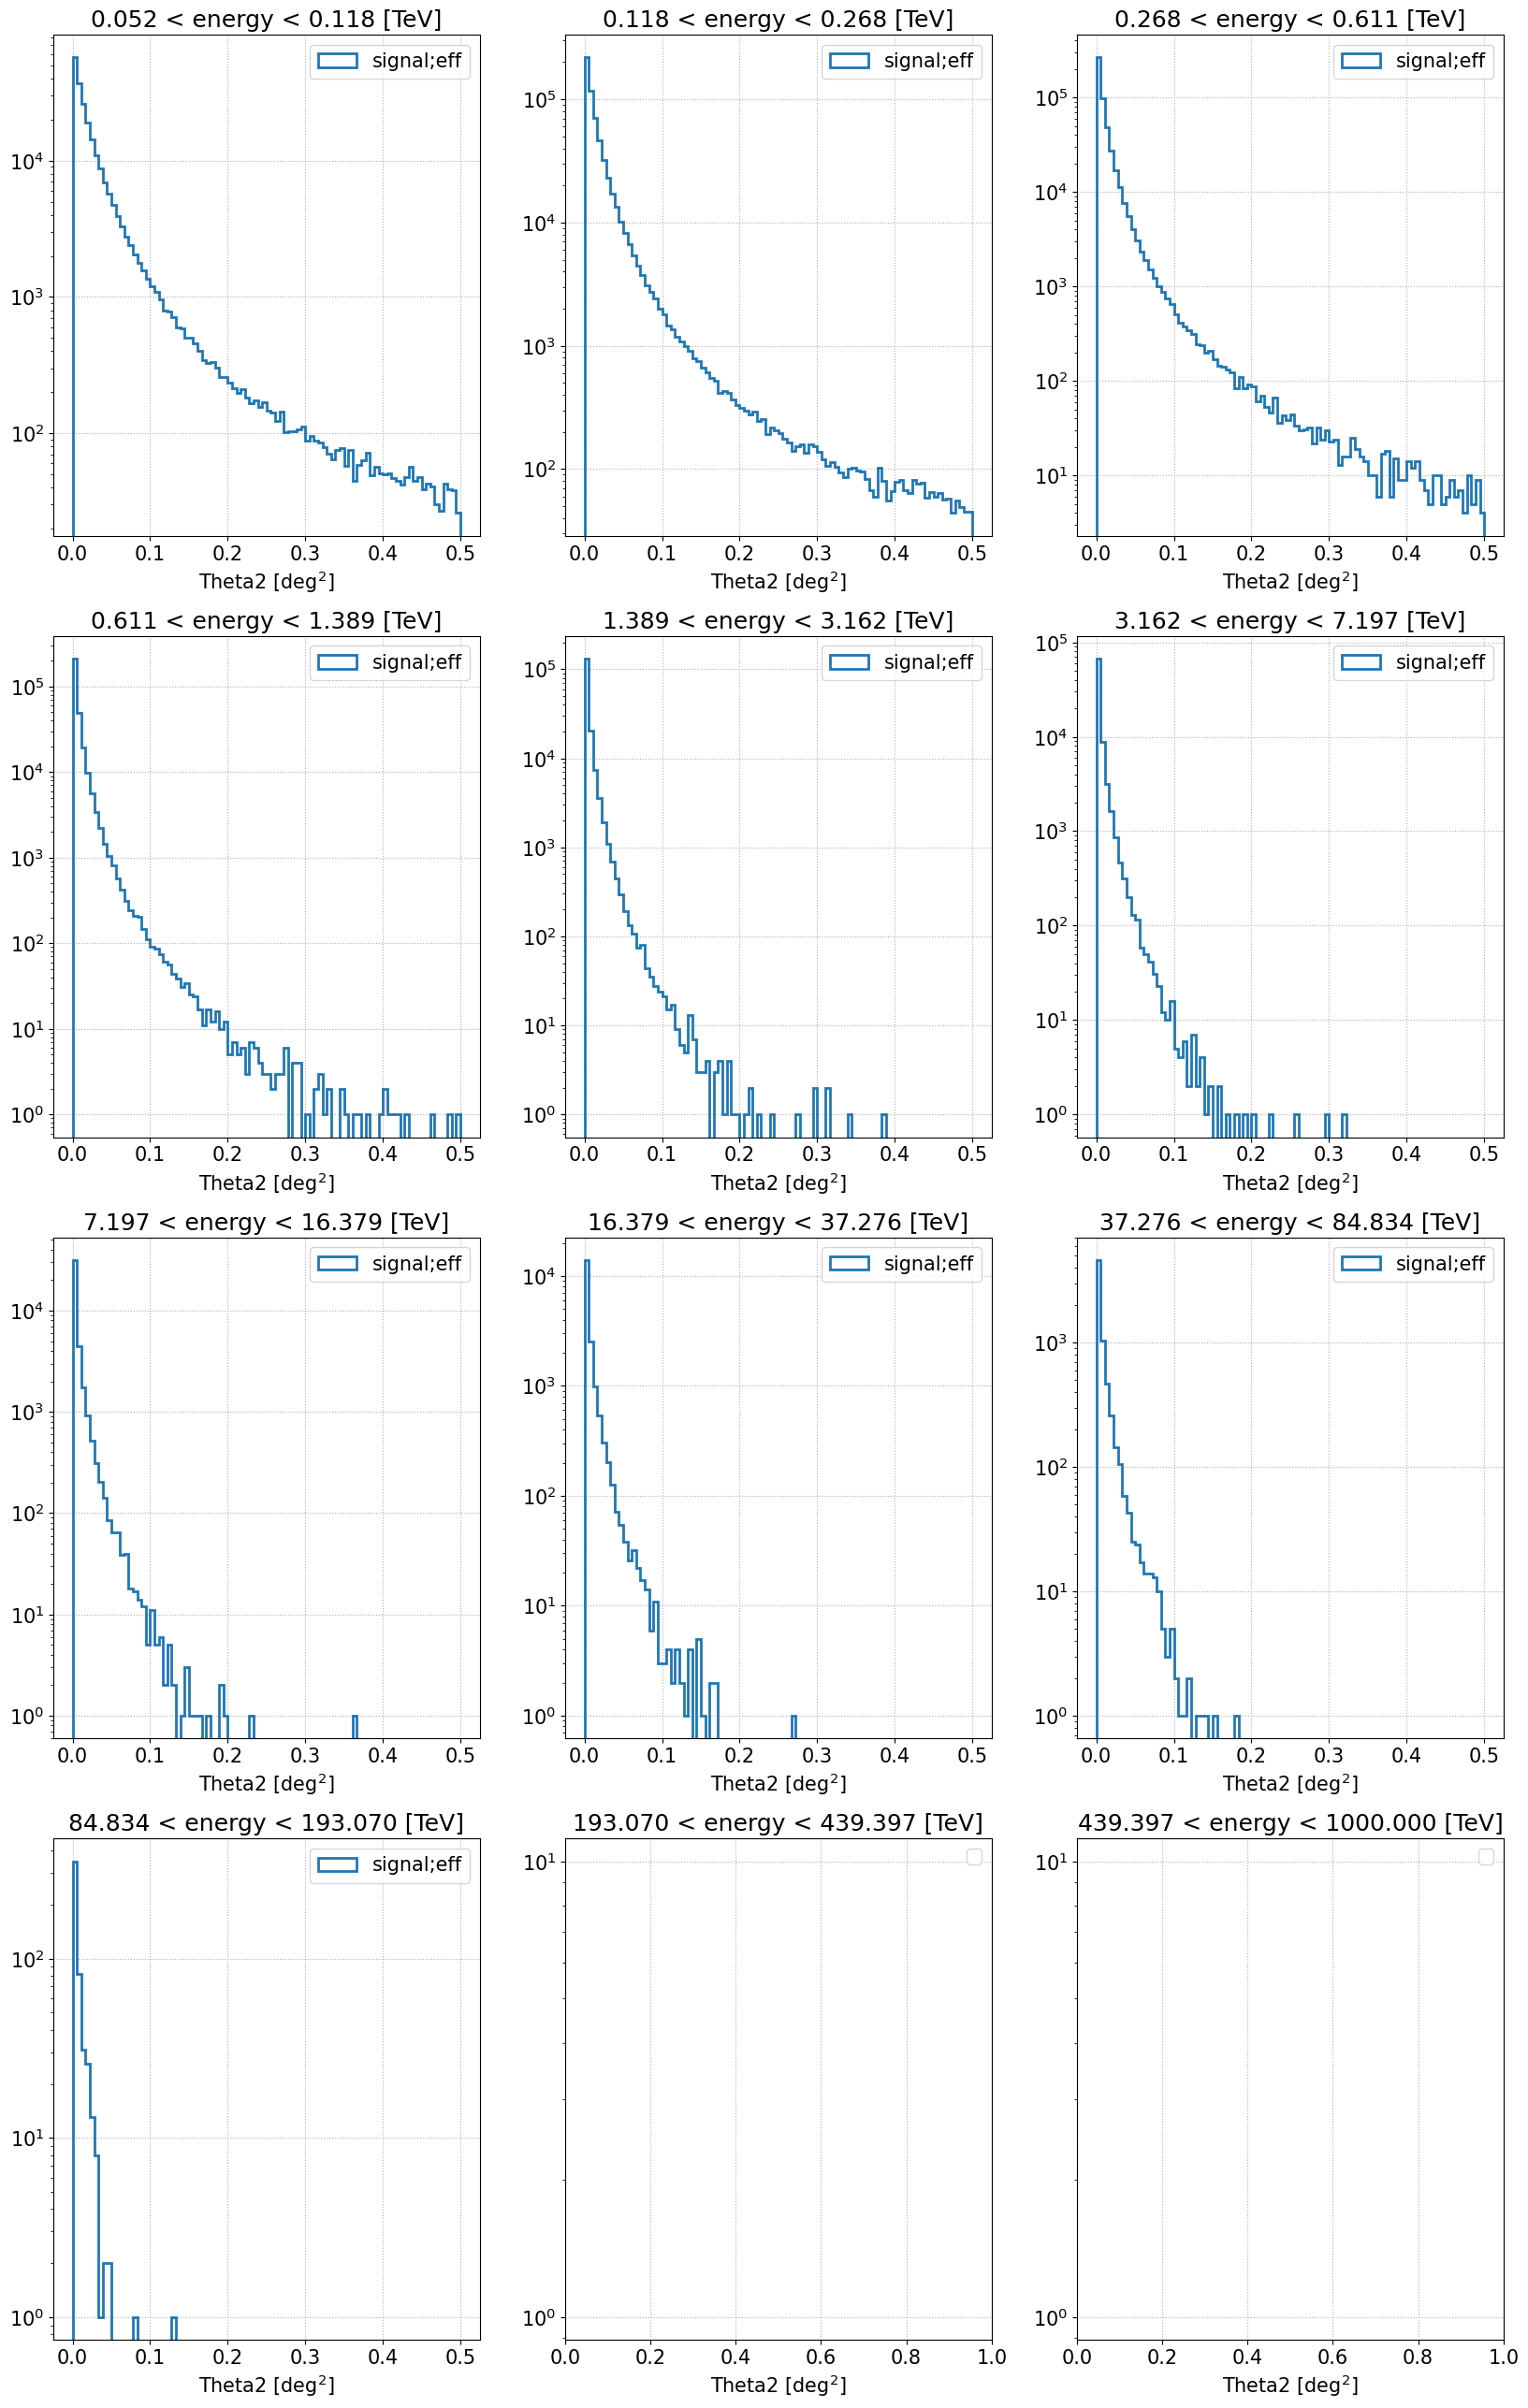

In [51]:
n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lolim:.3f} < energy < {eng_uplim:.3f} [TeV]")
    plt.xlabel("Theta2 [deg$^2$]")
    plt.yscale(yscale)
    plt.grid()

    # Apply the energy cuts
    cond_eff_lolim = data_eff_gcut["reco_energy"].value > eng_lolim
    cond_eff_uplim = data_eff_gcut["reco_energy"].value < eng_uplim

    
    
    condition_eff = np.logical_and(cond_eff_lolim, cond_eff_uplim)

    
    dt_eff = data_eff_gcut[condition_eff]
    dte=np.array(dt_eff["theta"].value)
    
    # Plot the theta2 distribution
    if len(dt_eff) > 0:
        plt.hist(
            np.square(dte),
            bins=theta2_bins,
            label="signal;eff",
            histtype="step",
            linewidth=2,
        )

    plt.legend(loc="upper right")


# Check the angular resolution

In [52]:


# Calculate the angular resolution
angres_table_eff = angular_resolution(
    data_eff_gcut, u.Quantity(energy_bins, u.TeV), energy_type="reco"
)

angres_eff = angres_table_eff["angular_resolution"].value
print(f"\n angular resolution:\n{angres_eff} deg")




 angular resolution:
[0.170286   0.13469737 0.09807467 0.0740526  0.06052632 0.05604803
 0.05859823 0.06640437 0.07594499 0.07702847        nan        nan] deg


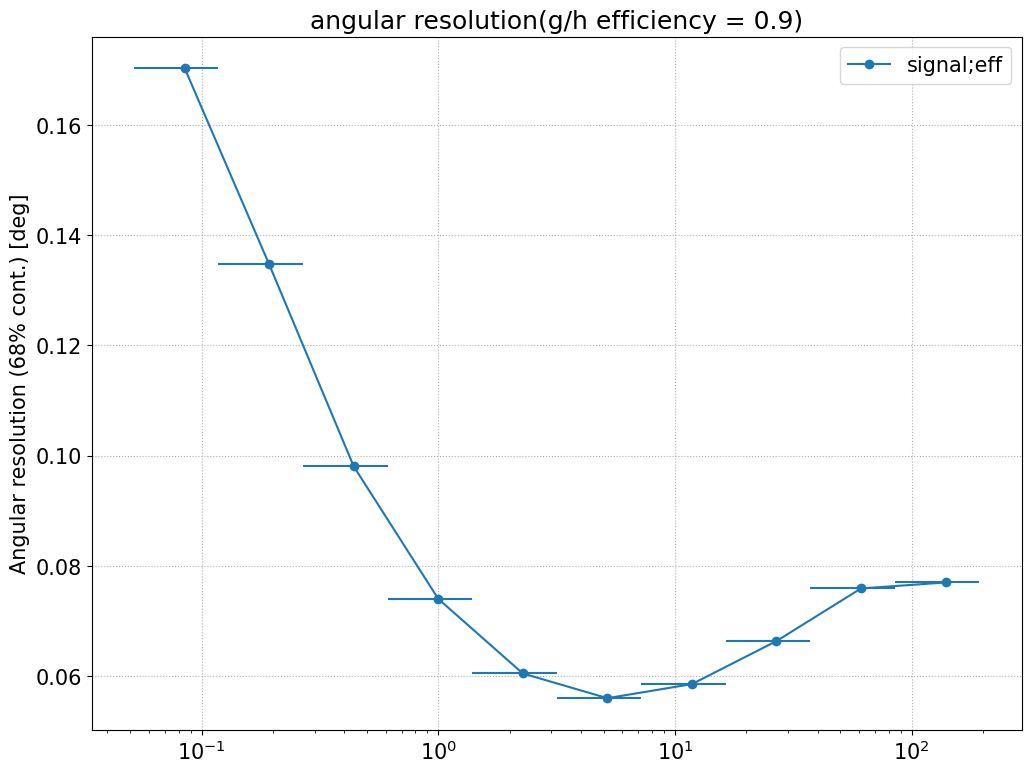

In [53]:
plt.figure()
gs = gridspec.GridSpec(4, 1)


plt.title(f"angular resolution(g/h efficiency = {gh_efficiency})")
plt.ylabel("Angular resolution (68% cont.) [deg]")
plt.semilogx()
plt.grid()




# Plot the angular resolution
plt.errorbar(
    x=energy_bins_center,
    y=angres_eff,
    xerr=energy_bins_width,
    label="signal;eff",
    marker="o",
)


plt.legend()


# Apply dynamic theta cuts

In [54]:
# ================
# === Settings ===
# ================
theta_efficiency_68=0.68
theta_efficiency = 0.8

# ============
# === Main ===
# ============



theta_percentile = 100 * theta_efficiency
theta_percentile_68 = 100 * theta_efficiency_68


# Calculate the dynamic theta cuts
theta_table_eff = calculate_percentile_cut(
    values=data_eff_gcut["theta"],
    bin_values=data_eff_gcut["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=data_eff_gcut["theta"].unmasked.max(),
    percentile=theta_percentile,
)
theta_table_eff_68= calculate_percentile_cut(
    values=data_eff_gcut["theta"],
    bin_values=data_eff_gcut["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=data_eff_gcut["theta"].unmasked.max(),
    percentile=theta_percentile_68,
)

theta_cuts_eff = theta_table_eff["cut"]
theta_cuts_eff_68 = theta_table_eff_68["cut"]

theta_cut_eff = theta_table_eff["cut"].value
theta_cut_eff_68 = theta_table_eff_68["cut"].value
print(f"\n(0.8 efficiency) theta cuts:\n{theta_cuts_eff}")
print(f"\n(0.68 efficiency) theta cuts:\n{theta_cuts_eff_68}")


(0.8 efficiency) theta cuts:
[0.21663363 0.17185746 0.12419518 0.09391394 0.07774459 0.07315223
 0.07802671 0.08704663 0.099206   0.0981244  3.4063575  0.28022565] deg

(0.68 efficiency) theta cuts:
[0.16943465 0.13401623 0.09759965 0.07366643 0.06019291 0.05573892
 0.05819868 0.06598556 0.07565809 0.07665327 3.4063575  0.21678472] deg


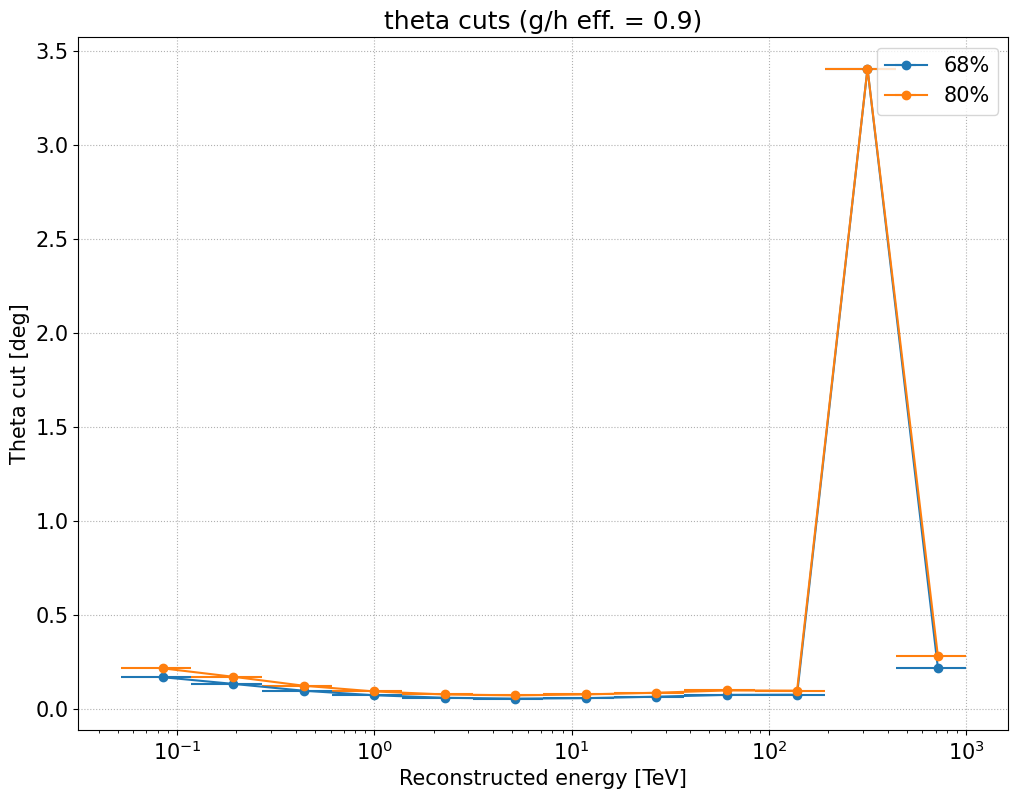

In [55]:
plt.figure()
plt.title(f"theta cuts (g/h eff. = {gh_efficiency})")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Theta cut [deg]")
plt.semilogx()
plt.grid()

# Plot the 68% dynamic theta cuts
plt.errorbar(
    x=energy_bins_center,
    y=theta_cuts_eff_68,
    xerr=energy_bins_width,
    label="68%",
    marker="o",
)

# Plot the 80% dynamic theta cuts
plt.errorbar(
    x=energy_bins_center,
    y=theta_cuts_eff,
    xerr=energy_bins_width,
    label="80%",
    marker="o",
)

plt.legend(loc="upper right")


In [56]:



# Apply dynamic theta cuts
print("\nApplying the theta cuts to signal;eff...")

mask_theta_eff = evaluate_binned_cut(
    values=data_eff_gcut["theta"],
    bin_values=data_eff_gcut["reco_energy"],
    cut_table=theta_table_eff,
    op=operator.le,
)

data_eff_gtcuts = data_eff_gcut[mask_theta_eff]
print(f"--> Number of events: {len(data_eff_gtcuts)}")


Applying the theta cuts to signal;eff...
--> Number of events: 1583455


# Check the effective area

Warning: effective area depends on azimuth: MCs with azimuth in a narrow range (~30 deg) must be provided as imput or you will get meaningless results

In [57]:


# Calculate the low zenith effective area
aeff_eff_26 = effective_area_per_energy(
    selected_events=data_eff_gcut_26,
    simulation_info=sim_isto_signal,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print(f"\neffective area:\n{aeff_eff_26}")


effective area:
[ 28282.75038875  78904.633225   128557.41062531 175206.57722432
 202612.58699386 223202.23840613 226014.40531347 218911.48637393
 112614.42288997      0.                     nan             nan] m2


In [58]:

# Calculate the mid zenith effective area
aeff_eff_46 = effective_area_per_energy(
    selected_events=data_eff_gcut_46,
    simulation_info=sim_isto_signal,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print(f"\neffective area:\n{aeff_eff_46}")


effective area:
[ 26575.76719929 160319.61541828 319843.54692564 455400.43127131
 562317.96863494 632056.0908681  686916.39738247 706861.39417632
 649447.8657258  222735.20429164             nan             nan] m2


In [59]:


# Calculate the high zenith effective area
aeff_eff_67 = effective_area_per_energy(
    selected_events=data_eff_gcut_67,
    simulation_info=sim_isto_signal,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print(f"\neffective area:\n{aeff_eff_67}")


effective area:
[  2107.12106366  45448.60284652 141550.73217327 222984.85054178
 288494.51738281 335052.22036262 375474.02180225 424861.57954089
 429597.13276116 386478.65893178             nan             nan] m2


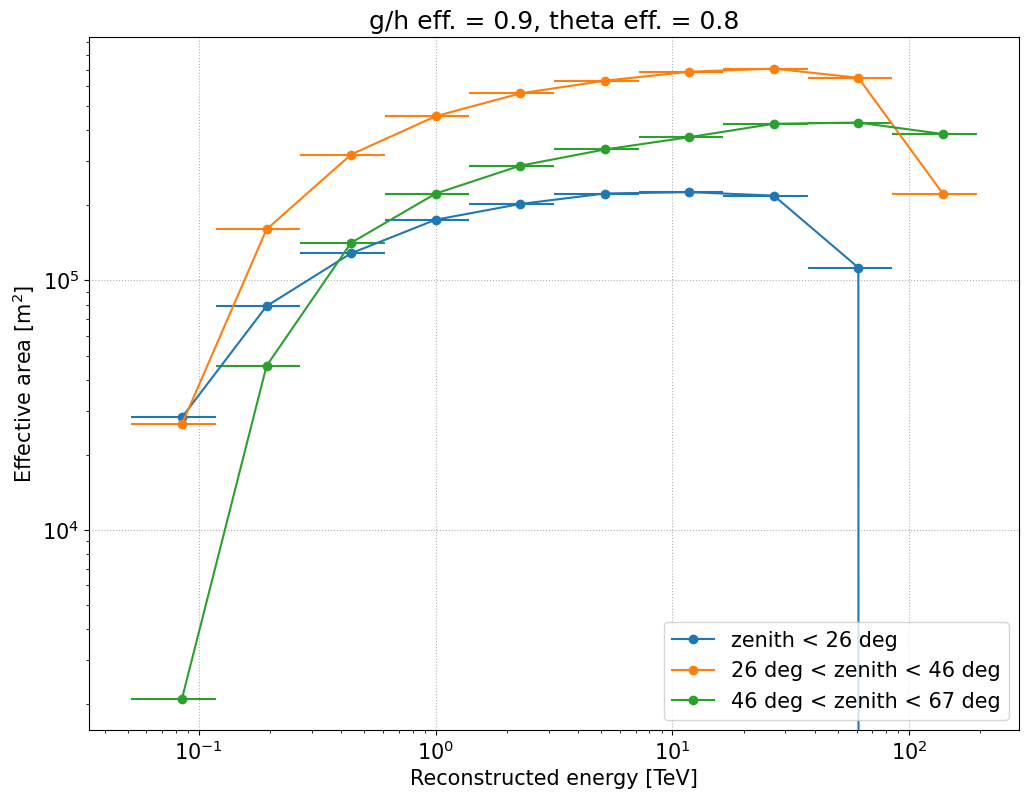

In [60]:
plt.figure()
plt.title(f"g/h eff. = {gh_efficiency}, theta eff. = {theta_efficiency}")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Effective area [m$^2$]")
plt.loglog()
plt.grid()


# Plot the effective area
plt.errorbar(
    x=energy_bins_center,
    y=aeff_eff_26.value,
    xerr=energy_bins_width,
    label="zenith < 26 deg",
    marker="o",
)


# Plot the effective area
plt.errorbar(
    x=energy_bins_center,
    y=aeff_eff_46.value,
    xerr=energy_bins_width,
    label="26 deg < zenith < 46 deg",
    marker="o",
)



# Plot the effective area
plt.errorbar(
    x=energy_bins_center,
    y=aeff_eff_67.value,
    xerr=energy_bins_width,
    label="46 deg < zenith < 67 deg",
    marker="o",
)

plt.legend(loc="lower right")


# Check the energy bias and resolution

In [61]:



# Calculate the  signal energy bias and resolution
engres_table_eff = energy_bias_resolution(
    data_eff_gcut, u.Quantity(energy_bins, u.TeV), energy_type="reco"
)

engbias_eff = engres_table_eff["bias"].value
engres_eff = engres_table_eff["resolution"].value

print(
    f"\n signal energy bias:\n{engbias_eff}"
    f"\n\n signal energy resolution:\n{engres_eff}"
)




 signal energy bias:
[ 0.08434323  0.01484467 -0.0250432  -0.02881922 -0.02607769 -0.02119713
 -0.00956669 -0.02226649 -0.05726443 -0.08706608         nan         nan]

 signal energy resolution:
[0.26199249 0.21791972 0.17256677 0.15014033 0.13673167 0.13407315
 0.14384866 0.16154088 0.18634288 0.13469422        nan        nan]


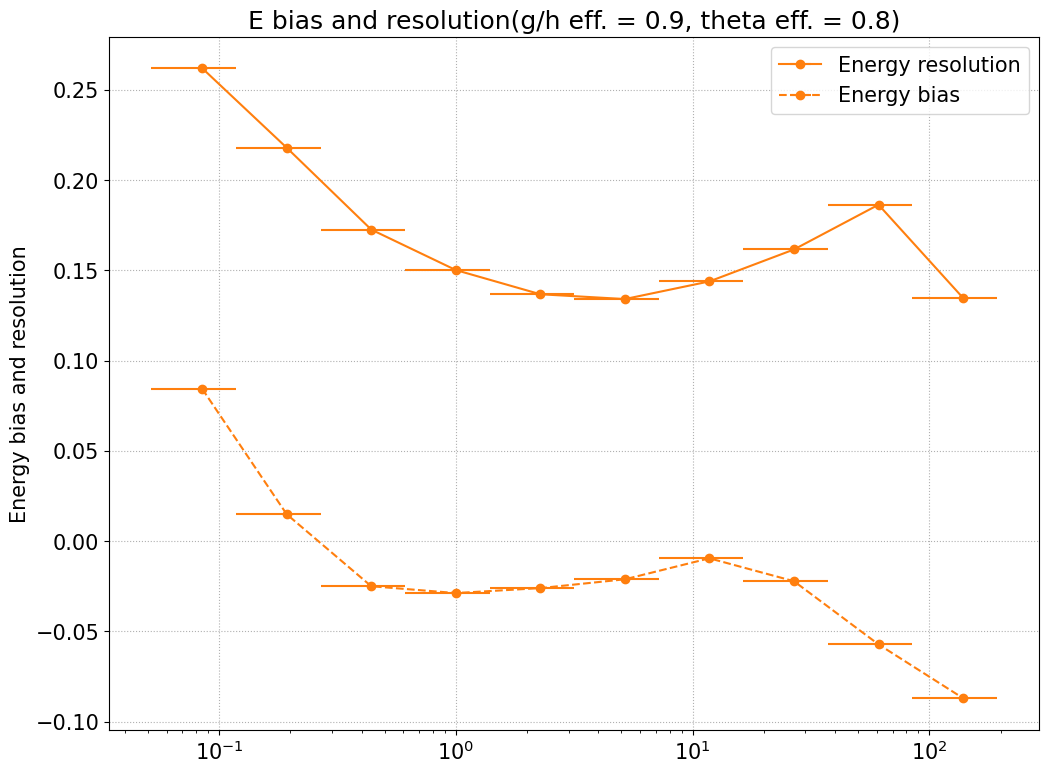

In [62]:
plt.figure()
gs = gridspec.GridSpec(4, 1)


plt.title(f"E bias and resolution(g/h eff. = {gh_efficiency}, theta eff. = {theta_efficiency})")
plt.ylabel("Energy bias and resolution")
plt.semilogx()
plt.grid()





# Plot the signal energy bias and resolution
plt.errorbar(
    x=energy_bins_center,
    y=engres_eff,
    xerr=energy_bins_width,
    label="Energy resolution",
    marker="o",
    color=colors[1],
)

plt.errorbar(
    x=energy_bins_center,
    y=engbias_eff,
    xerr=energy_bins_width,
    label="Energy bias",
    marker="o",
    linestyle="--",
    color=colors[1],
)


plt.legend()


# Plots: cut effects on background

In [63]:

back_gn_cut_eff=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    mask_table_eff=(background_hist["reco_energy"].value >np.repeat(eng_lo,(len(background_hist)))) \
        & (background_hist["reco_energy"].value <np.repeat(eng_hi,(len(background_hist)))) \
            & (background_hist["gammaness"].value>np.repeat(gh_table_eff['cut'][i_bin],(len(background_hist))))
    back_masked_gn_eff=background_hist[mask_table_eff]
    back_gn_cut_eff=vstack([back_masked_gn_eff,back_gn_cut_eff])
    print(len(back_masked_gn_eff))
print("tot",len(back_gn_cut_eff))
back_gn_cut_eff

340
452
194
55
4
2
0
1
1
0
0
0
tot 1049


col0,obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,84003,4262608,3,3,59.21390914916992,44.76406602773934,274.25482604556976,0.7866722022187959,4.787158965217607,38.94441732295422,45.021993367341764,274.17358014257735,0.5312818523665612,0.2642711904486941,0.3096211788064148,0.09320966454317446
--,86002,528304,3,3,33.41667556762695,52.393339519319376,271.18162340965756,0.9134878932659566,4.7239255901298804,24.61371020644158,52.3814048900781,271.10287658691817,0.6768517634924187,0.04952040051211829,0.32250979271889346,0.27316341150848
--,26902,5255206,3,3,6.527000904083252,51.771327851984665,270.8023839861817,0.9134878932659566,4.7239255901298804,4.425961826856665,51.71442821535641,270.8426659888898,0.8568430448193042,0.062126366973424,0.574291346478239,0.6344956853889673
--,87503,274405,3,3,5.101036548614502,45.118860204175654,274.19690604140806,0.7866722022187959,4.787158965217607,3.5676866387001382,45.11659169754801,274.169227414456,0.9728299889130265,0.019662787056279628,0.07670595249107873,0.09200865531200682
--,94001,2654503,3,3,4.102376937866211,59.53450378714823,265.9785219037252,1.0403907861416788,4.648859029322884,1.4844181559958105,59.32350474872912,265.7808015568945,0.8852778137456049,0.23373730707299922,0.20742794382800878,0.41068775671233404
--,42302,2449009,3,3,3.383066177368164,52.79666901999781,270.1802630358203,0.9134878932659566,4.7239255901298804,2.2568436422270417,52.69806507781018,270.0943052321234,0.9541473461732581,0.11149060133495087,0.5429906815242801,0.4978311743173047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
--,81603,4088103,2,2,0.28194287419319153,45.49691458983044,274.69294169969106,0.7866722022187959,4.787158965217607,0.08626418244337956,45.60253372995648,274.9321579979859,0.7392201905959925,0.19803676925647287,0.512335313265455,0.6985534338031694


In [64]:

ttheta_table_eff=Table(theta_table_eff)
ttheta_table_eff_68=Table(theta_table_eff_68)

In [65]:
#theta 68%,eff
back_theta_cut_eff_68=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    mask_table_theta_eff_68=(back_gn_cut_eff["reco_energy"].value >np.repeat(eng_lo,(len(back_gn_cut_eff)))) \
        & (back_gn_cut_eff["reco_energy"].value <np.repeat(eng_hi,(len(back_gn_cut_eff)))) \
            & (back_gn_cut_eff["theta"].value < np.repeat(theta_cut_eff_68[i_bin],(len(back_gn_cut_eff))))
    back_masked_theta_eff_68=back_gn_cut_eff[mask_table_theta_eff_68]
    back_theta_cut_eff_68=vstack([back_masked_theta_eff_68,back_theta_cut_eff_68])
    print(len(back_masked_theta_eff_68))
print("tot",len(back_theta_cut_eff_68))

33
76
44
13
1
1
0
1
0
0
0
0
tot 169


In [66]:
#theta 80%,eff
back_theta_cut_eff_80=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    mask_table_theta_eff_80=(back_gn_cut_eff["reco_energy"].value >np.repeat(eng_lo,(len(back_gn_cut_eff)))) \
        & (back_gn_cut_eff["reco_energy"].value <np.repeat(eng_hi,(len(back_gn_cut_eff)))) \
            & (back_gn_cut_eff["theta"].value < np.repeat(theta_cut_eff[i_bin],(len(back_gn_cut_eff))))
    back_masked_theta_eff_80=back_gn_cut_eff[mask_table_theta_eff_80]
    back_theta_cut_eff_80=vstack([back_masked_theta_eff_80,back_theta_cut_eff_80])
    print(len(back_masked_theta_eff_80))
print("tot",len(back_theta_cut_eff_80))

47
115
67
22
2
2
0
1
0
0
0
0
tot 256


Plot

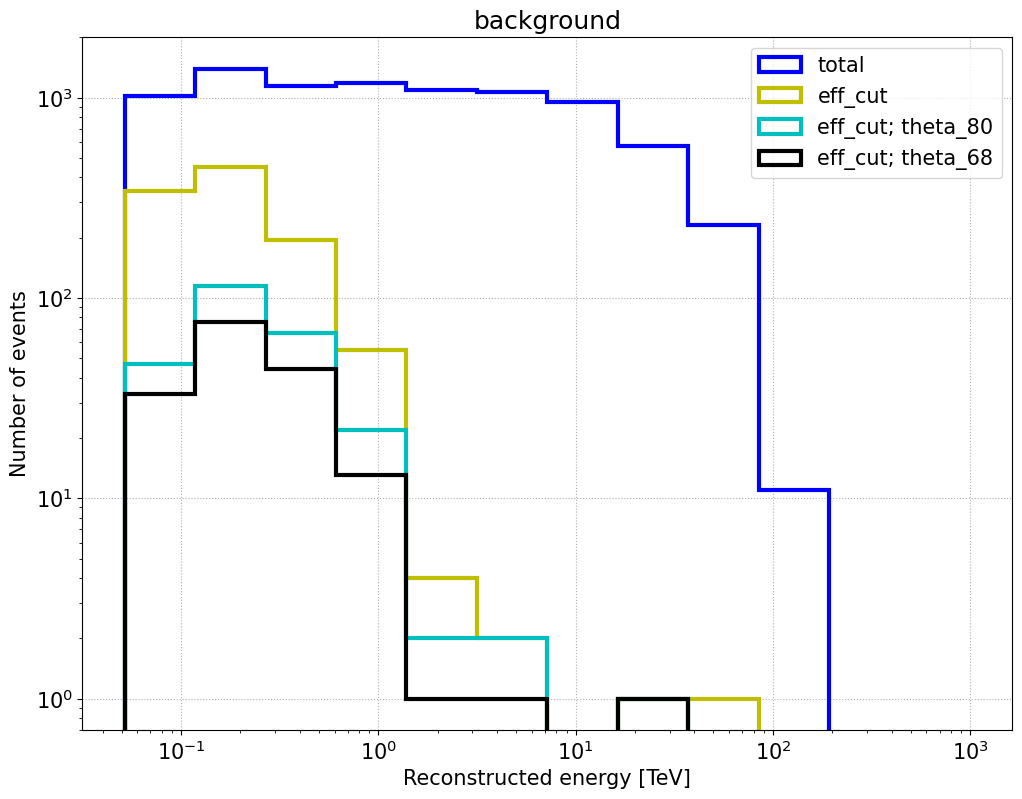

In [67]:
plt.figure()
plt.title("background")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Number of events")
plt.semilogx()
plt.yscale(yscale)
plt.grid()

theta_80_eff=np.array(back_theta_cut_eff_80["reco_energy"].value)
theta_68_eff=np.array(back_theta_cut_eff_68["reco_energy"].value)
gn_eff=np.array(back_gn_cut_eff["reco_energy"].value)
tot_back=np.array(background_hist["reco_energy"].value)
# before cuts
plt.hist(
    tot_back,
    bins=energy_bins,
    label="total",
    histtype="step",
    linewidth=3,
    color="b"
)




#gammaness cut
plt.hist(
    gn_eff,
    bins=energy_bins,
    label="eff_cut",
    histtype="step",
    linewidth=3,
    color="y"
)


#theta 80%, eff
plt.hist(
    theta_80_eff,
    bins=energy_bins,
    label="eff_cut; theta_80",
    histtype="step",
    linewidth=3,
    color="c"
)
#theta 68%, eff
plt.hist(
    theta_68_eff,
    bins=energy_bins,
    label="eff_cut; theta_68",
    histtype="step",
    linewidth=3,
    color="k"
)


plt.legend()



# Plots: cut effects on signal

In [68]:


sig_gn_cut_eff=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    mask_E=np.logical_and((signal_hist["reco_energy"].value >np.repeat(eng_lo,(len(signal_hist)))), \
        (signal_hist["reco_energy"].value <np.repeat(eng_hi,(len(signal_hist)))))
    mask_table_eff_sig=np.logical_and(mask_E,(signal_hist["gammaness"].value>np.repeat(gh_table_eff['cut'][i_bin],(len(signal_hist)))))
    sig_masked_gn_eff=signal_hist[mask_table_eff_sig]
    sig_gn_cut_eff=vstack([sig_masked_gn_eff,sig_gn_cut_eff])
    print(len(sig_masked_gn_eff))
print("tot",len(sig_gn_cut_eff))
sig_gn_cut_eff

228470
615644
503713
306923
167587
82831
40186
18936
6889
515
0
0
tot 1971694


col0,obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,106,1840609,3,3,77.16156005859375,46.404257409742435,262.7578145024974,0.8168665607739516,4.5851893215425985,85.52127608523992,46.34985096438853,262.7089967153393,0.6562629249275175,0.06398744838270831,0.39998953706764584,0.4531600842854903
--,606,221203,3,3,74.06979370117188,46.955194128574,263.2513093304092,0.8168665607739516,4.5851893215425985,95.23327288420462,46.92069024094224,263.16772512857443,0.9092983474023845,0.06668999580397347,0.39881970353595797,0.3330904383044528
--,806,1056400,3,3,99.78175354003906,46.40406274935109,262.66899472253056,0.8168665607739516,4.5851893215425985,92.07480367925376,46.52949908375809,262.64496154571174,0.6521334956037554,0.1265238723779445,0.4000360411413109,0.27734894471485155
--,1006,202003,3,3,70.68499755859375,47.196398844018425,262.8154612990923,0.8168665607739516,4.5851893215425985,87.28168348746189,47.10205300320822,262.74186823214353,0.9801462489237642,0.10679952034305674,0.3996707873873315,0.299741005102139
--,1106,1215800,3,3,91.01921844482422,47.20225231613713,262.74639442620514,0.8168665607739516,4.5851893215425985,92.76315645039068,47.05192856972587,262.7891094177825,0.8091019050809772,0.1531072739187101,0.3999345131271726,0.2544318511182428
--,1106,1215804,3,3,91.01921844482422,47.20225231613713,262.74639442620514,0.8168665607739516,4.5851893215425985,98.34574295165132,47.20526230706265,262.7150108297929,0.927332983913106,0.02153321297906208,0.3999345131271726,0.40226120187923736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
--,49904,1405503,2,2,0.12741325795650482,42.012558471545546,270.5363617783881,0.7338760535490454,4.71238899230957,0.09766888956851767,41.81885025913415,270.3962644166336,0.749855769914366,0.21997951507691327,0.39997693627192954,0.3733764866149532


In [69]:

ttheta_table_eff=Table(theta_table_eff)
ttheta_table_eff_68=Table(theta_table_eff_68)

In [70]:
#theta 68%,eff
sig_theta_cut_eff_68=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    mask_table_theta_eff_68_sig=(sig_gn_cut_eff["reco_energy"].value >np.repeat(eng_lo,(len(sig_gn_cut_eff)))) \
        & (sig_gn_cut_eff["reco_energy"].value <np.repeat(eng_hi,(len(sig_gn_cut_eff)))) \
            & (sig_gn_cut_eff["theta"].value<np.repeat(theta_cut_eff_68[i_bin],(len(sig_gn_cut_eff))))
    sig_masked_theta_eff_68=sig_gn_cut_eff[mask_table_theta_eff_68_sig]
    sig_theta_cut_eff_68=vstack([sig_masked_theta_eff_68,sig_theta_cut_eff_68])
    print(len(sig_masked_theta_eff_68))
print("tot",len(sig_theta_cut_eff_68))

155359
418638
342525
208707
113959
56325
27326
12876
4684
350
0
0
tot 1340749


In [71]:
#theta 80%,eff
sig_theta_cut_eff_80=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    mask_table_theta_eff_80_sig=(sig_gn_cut_eff["reco_energy"].value >np.repeat(eng_lo,(len(sig_gn_cut_eff)))) \
        & (sig_gn_cut_eff["reco_energy"].value <np.repeat(eng_hi,(len(sig_gn_cut_eff)))) \
            & (sig_gn_cut_eff["theta"].value<np.repeat(theta_cut_eff[i_bin],(len(sig_gn_cut_eff))))
    sig_masked_theta_eff_80=sig_gn_cut_eff[mask_table_theta_eff_80_sig]
    sig_theta_cut_eff_80=vstack([sig_masked_theta_eff_80,sig_theta_cut_eff_80])
    print(len(sig_masked_theta_eff_80))
print("tot",len(sig_theta_cut_eff_80))

182776
492515
402970
245538
134069
66264
32148
15148
5511
412
0
0
tot 1577351


Plot

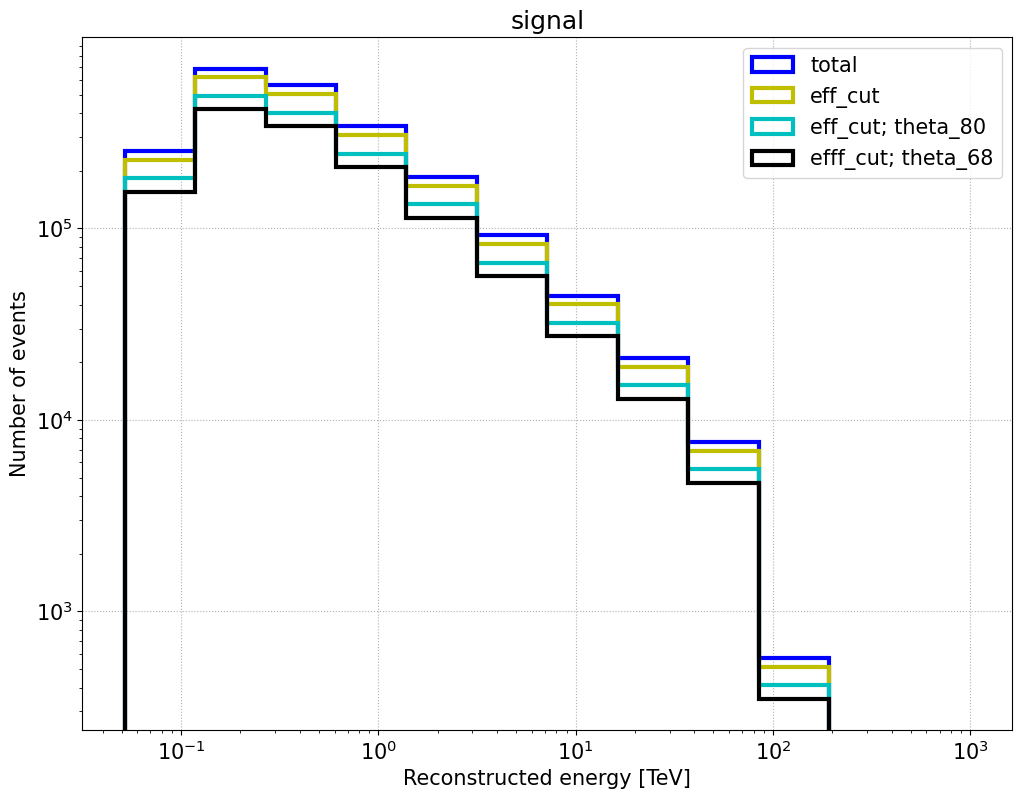

In [72]:
plt.figure()
plt.title("signal")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Number of events")
plt.semilogx()
plt.yscale(yscale)
plt.grid()

theta_80_eff_sig=np.array(sig_theta_cut_eff_80["reco_energy"].value)
theta_68_eff_sig=np.array(sig_theta_cut_eff_68["reco_energy"].value)
gn_eff_sig=np.array(sig_gn_cut_eff["reco_energy"].value)
sE=np.array(signal_hist["reco_energy"].value)
# before cuts
plt.hist(
    sE,
    bins=energy_bins,
    label="total",
    histtype="step",
    linewidth=3,
    color="b"
)




#gammaness cut
plt.hist(
    gn_eff_sig,
    bins=energy_bins,
    label="eff_cut",
    histtype="step",
    linewidth=3,
    color="y"
)

#theta 80%, eff
plt.hist(
    theta_80_eff_sig,
    bins=energy_bins,
    label="eff_cut; theta_80",
    histtype="step",
    linewidth=3,
    color="c"
)
#theta 68%, eff
plt.hist(
    theta_68_eff_sig,
    bins=energy_bins,
    label="efff_cut; theta_68",
    histtype="step",
    linewidth=3,
    color="k"
)
plt.legend()
